In [1]:
import pandas as pd
import numpy as np
import git
from datetime import datetime as dt
from connect_to_mysql import Database
pd.set_option("display.max_columns", None)

In [2]:
repo = git.Repo(".", search_parent_directories=True).git.rev_parse("--show-toplevel")
#df = pd.read_csv(f"{repo}/data/cleaning/test_1651834681.csv")
#df = df[(df["state"] == "completed")]

In [3]:
Database.query_dataframe('rides', 'Show tables')

/Users/ericchittka/Library/Python/3.8/lib/python/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Tables_in_teamproject
0,modstop
1,rides
2,testtable


In [4]:
df = Database.query_dataframe('rides', "Select * From rides where state = 'completed'")

/Users/ericchittka/Library/Python/3.8/lib/python/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
# df_edges = Database.query_dataframe('modstop_Liste22', "Select * From modstop_Liste22")

### Number of Drives 

In [6]:
df.columns

Index(['db_updated_at', 'id', 'user_id', 'distance', 'number_of_passenger',
       'price_operations', 'price_offer', 'price_payed', 'free_ride',
       'payment_type', 'bahn_card_number', 'year_card_type',
       'year_card_number', 'pickup_address', 'dropoff_address', 'state',
       'created_from_offer', 'created_at', 'scheduled_to', 'dispatched_at',
       'canceled_at', 'pickup_arrival_time', 'arriving_push',
       'vehicle_arrived_at', 'earliest_pickup_expectation', 'pickup_first_eta',
       'pickup_eta', 'pickup_at', 'dropoff_first_eta', 'dropoff_eta',
       'dropoff_at', 'updated_at', 'arrival_deviation', 'waiting_time',
       'boarding_time', 'ride_time', 'trip_time', 'shortest_ridetime', 'delay',
       'longer_route_factor', 'arrival_indicator', 'rating',
       'rating_puenktlichkeit', 'rating_sauberkeit', 'rating_fahrer',
       'rating_find_modstop', 'rating_other_comments', 'rating_question_one',
       'rating_question_two', 'cancellation_reason', 'cancellation_comm

In [7]:
pd.to_datetime(df["scheduled_to"])[0].month

3

In [8]:
frequencies = pd.DataFrame(df[(pd.to_datetime(df["scheduled_to"]).dt.month == 2) & (pd.to_datetime(df["scheduled_to"]).dt.year == 2022) ].groupby(["pickup_address", "dropoff_address"], group_keys=False).size().to_frame('number_of_drives')).reset_index()

frequencies

,pickup_address,dropoff_address,number_of_drives
0,1001,1005,2
1,1001,12011,1
2,1002,1008,9
3,1002,1012,1
4,1002,16009,6
...,...,...,...
593,17007,4020,1
594,17007,4037,1
595,17007,11012,1
596,18005,9005,1


In [9]:
frequencies["pickup_address"] = frequencies["pickup_address"].astype(str)
frequencies["dropoff_address"] = frequencies["dropoff_address"].astype(str)

In [10]:
df_edges = pd.read_excel(
        f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="Liste 2022"
)

In [11]:
df_edges.columns

Index([                      'Start #',                    'Start Name',
                              'Ende #',                     'Ende Name',
                           'Route [m]',                 'Luftlinie [m]',
           'VRN-eTarif\nohne Bahncard',      'VRN-eTarif\nmit BahnCard',
                   'Qualitätszuschlag', 'MoD-Fahrpreis \nohne BahnCard',
        'MoD-Fahrpreis\n mit Bahncard',             0.12680550240634963,
                   0.07159177456207169,             0.18042226487523982,
                    0.5159630940478845,              0.2894135567402895,
                      0.72936660268714,                     'price_mod',
                     'price_mod_2pers',               'price_mod_3pers',
                     'price_mod_4pers',                'price_bahncard',
                'price_bahncard_2pers',          'price_bahncard_3pers',
                'price_bahncard_4pers',           'price_vrn_surcharge',
           'price_vrn_surcharge_2pers',     'price_

In [12]:
df_edges = df_edges[["Start #", "Ende #"]]

In [13]:
df_edges["Start #"] = df_edges["Start #"].astype(str)
df_edges["Ende #"] = df_edges["Ende #"].astype(str)

In [14]:
edges = pd.merge(df_edges, frequencies,  how='left', left_on=['Start #','Ende #'], right_on = ['pickup_address','dropoff_address'])[["Start #", "Ende #", "number_of_drives"]]
edges = edges[edges["number_of_drives"].isna() == False]
edges["number_of_drives"] = 28  / edges["number_of_drives"] 

In [15]:
edges

,Start #,Ende #,number_of_drives
3,1001,1005,14.000000
161,1001,12011,28.000000
206,1002,1008,3.111111
210,1002,1012,28.000000
396,1002,16009,4.666667
...,...,...,...
39869,17007,4020,28.000000
39886,17007,4037,28.000000
39946,17007,11012,28.000000
40114,18005,9005,28.000000


In [16]:
edges["number_of_drives"].fillna(0, inplace=True)

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(
    edges,
    source = "Start #",
    target = "Ende #",
    edge_attr= "number_of_drives"
)

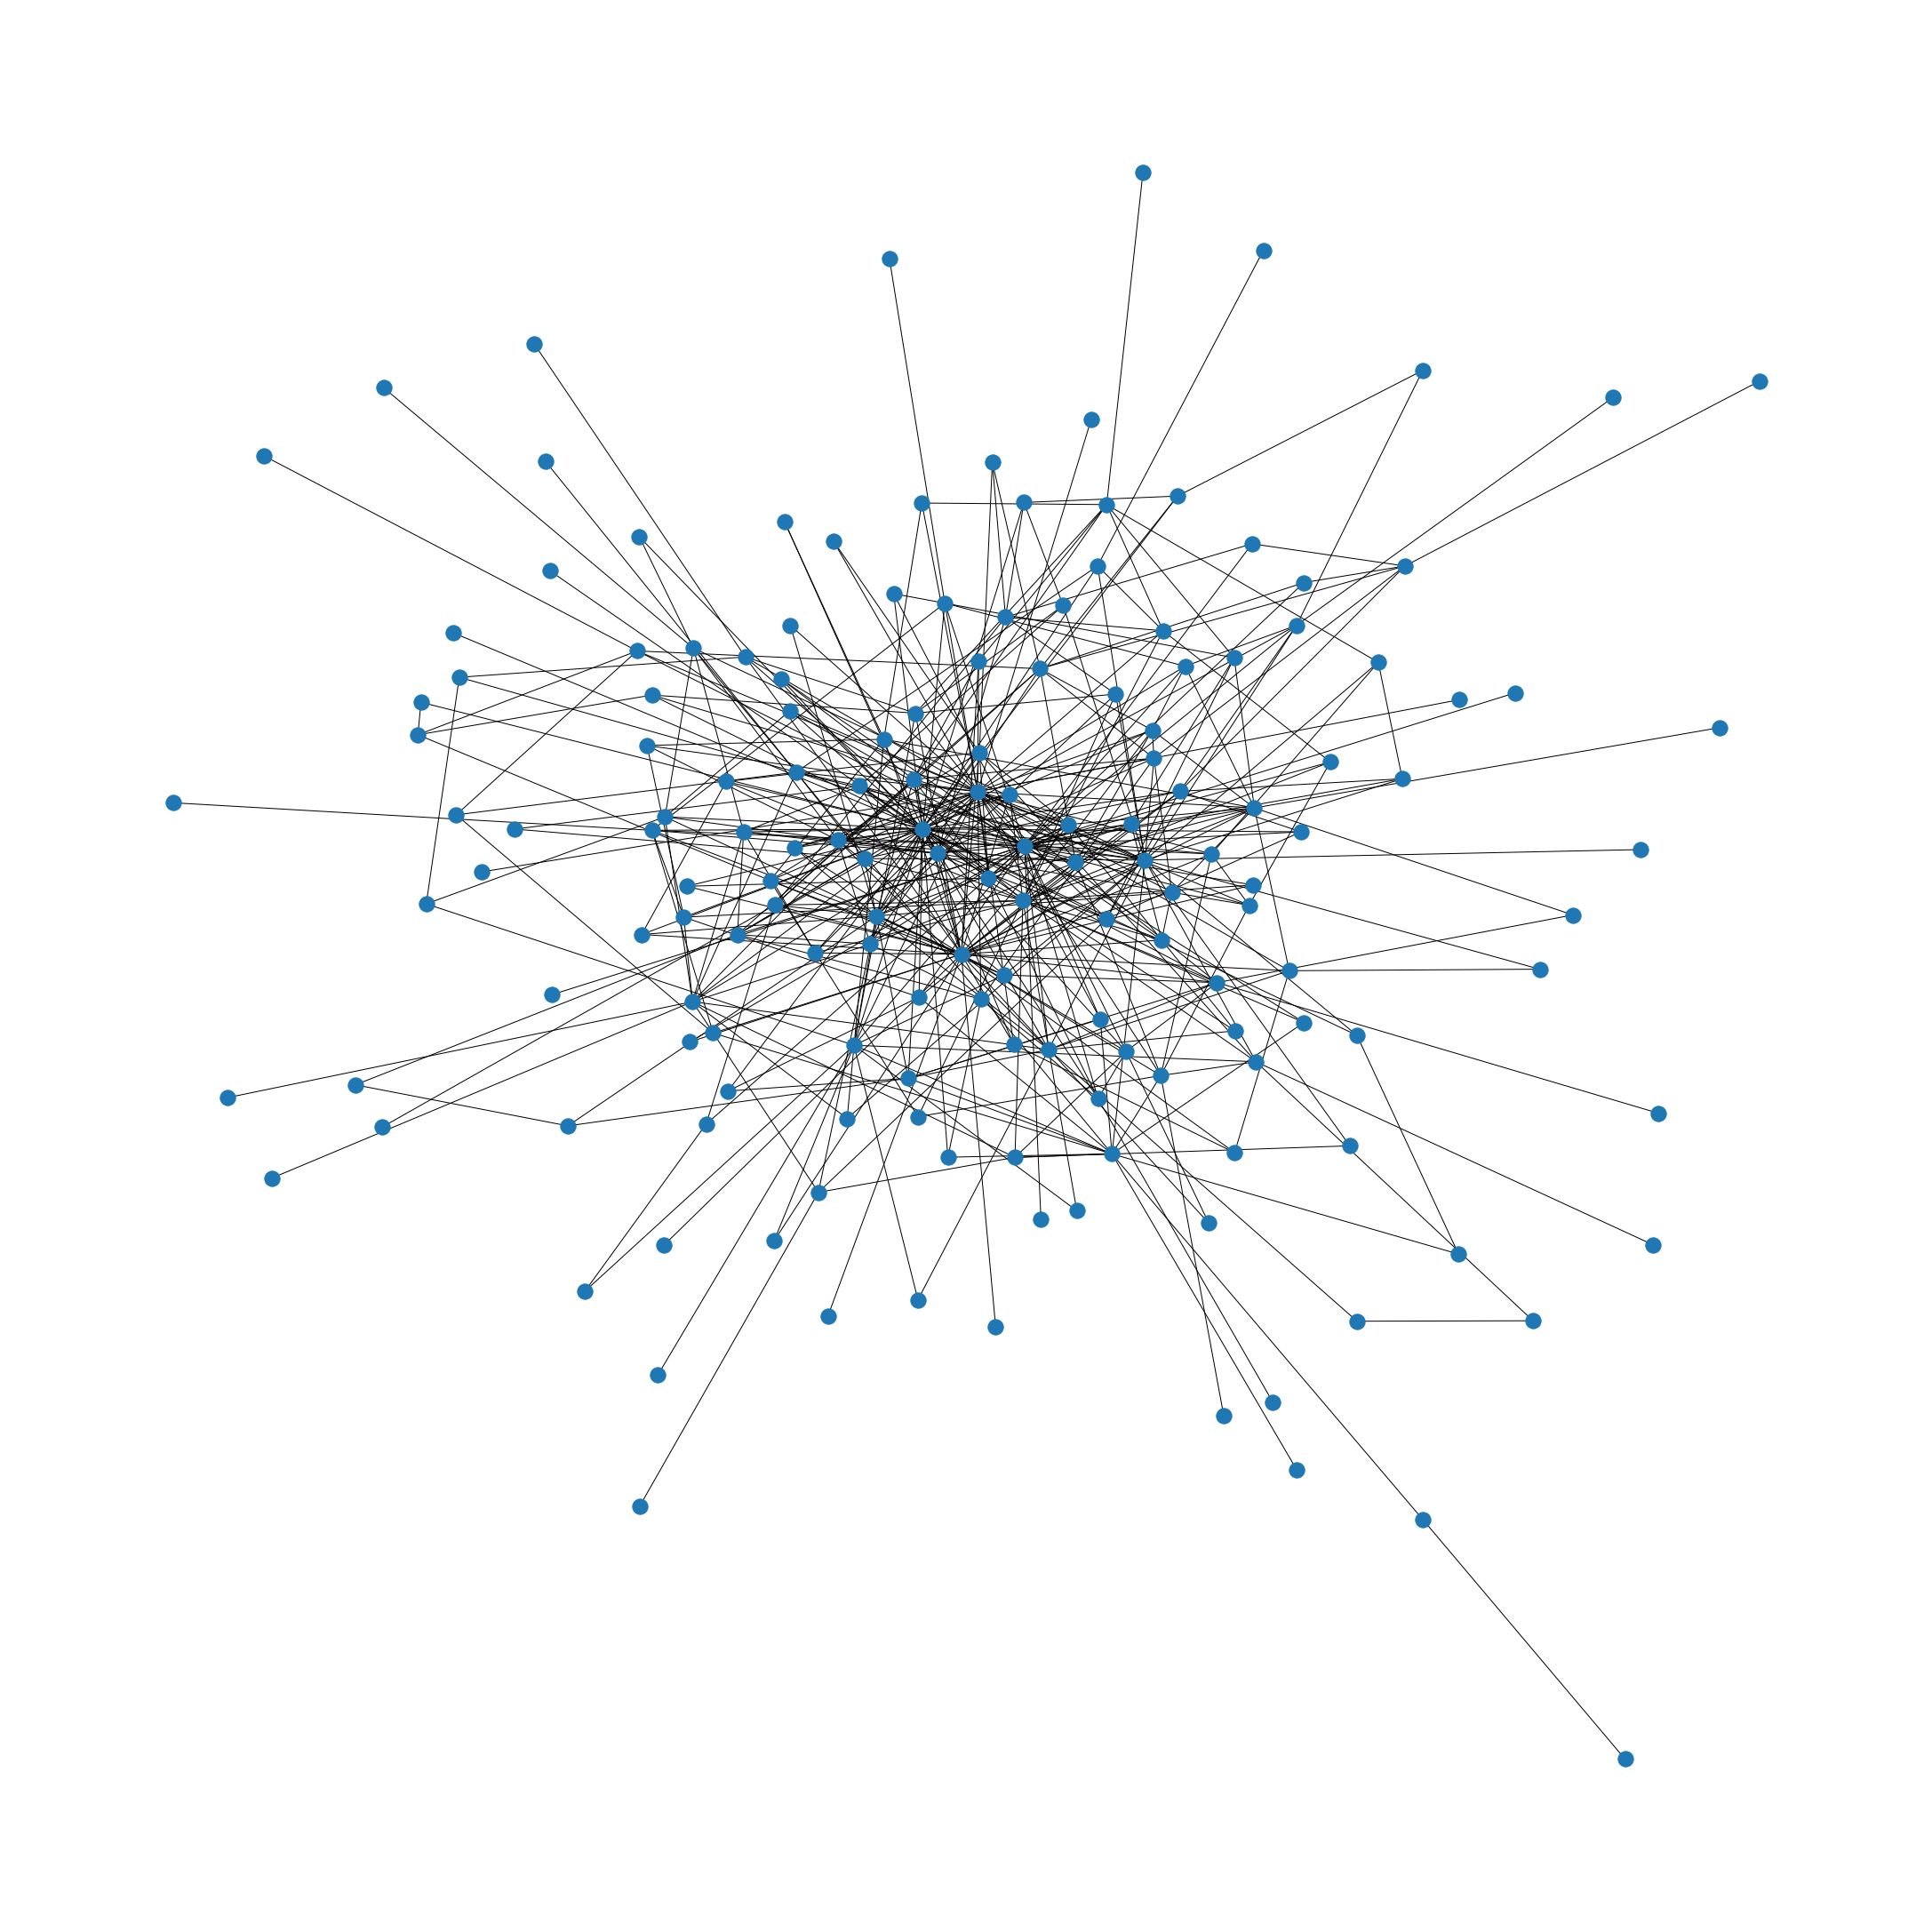

In [18]:
plt.figure(3,figsize=(30,30)) 
nx.draw(G)
plt.show()

In [19]:
print(nx.shortest_path(G, source="10002", target="4007", weight = "number_of_drives"))
print(nx.shortest_path_length(G, source="10002", target="4007", weight="number_of_drives", method='dijkstra'))

['10002', '1005', '4033', '1008', '4007']
77.0


### Average Ride Time per drive  

In [20]:
#df
#df.dtypes['ride_time']

In [21]:
average = pd.DataFrame(df.groupby(["pickup_address", "dropoff_address"], as_index=False, group_keys=False)["ride_time"].mean())
average.rename(columns = {"ride_time":"avg_ride_time"}, inplace = True)
average

,pickup_address,dropoff_address,avg_ride_time
0,1001,1004,150.200000
1,1001,1005,134.111111
2,1001,1008,305.666667
3,1001,1012,659.000000
4,1001,1013,506.000000
...,...,...,...
2271,18005,7001,579.250000
2272,18005,9001,880.000000
2273,18005,9005,798.000000
2274,18005,9006,791.000000


In [22]:
average["pickup_address"] = average["pickup_address"].astype(str)
average["dropoff_address"] = average["dropoff_address"].astype(str)

In [23]:
edges2 = pd.merge(df_edges, average,  how='left', left_on=['Start #','Ende #'], right_on = ['pickup_address','dropoff_address'])[["Start #", "Ende #", "avg_ride_time"]]
edges2 = edges2[edges2["avg_ride_time"].isna() == False]
edges2

,Start #,Ende #,avg_ride_time
2,1001,1004,150.200000
3,1001,1005,134.111111
6,1001,1008,305.666667
10,1001,1012,659.000000
11,1001,1013,506.000000
...,...,...,...
40107,18005,7001,579.250000
40110,18005,9001,880.000000
40114,18005,9005,798.000000
40115,18005,9006,791.000000


In [24]:
import networkx as nx
import matplotlib.pyplot as plt
G1 = nx.from_pandas_edgelist(
    edges2,
    source = "Start #",
    target = "Ende #",
    edge_attr= "avg_ride_time"
)

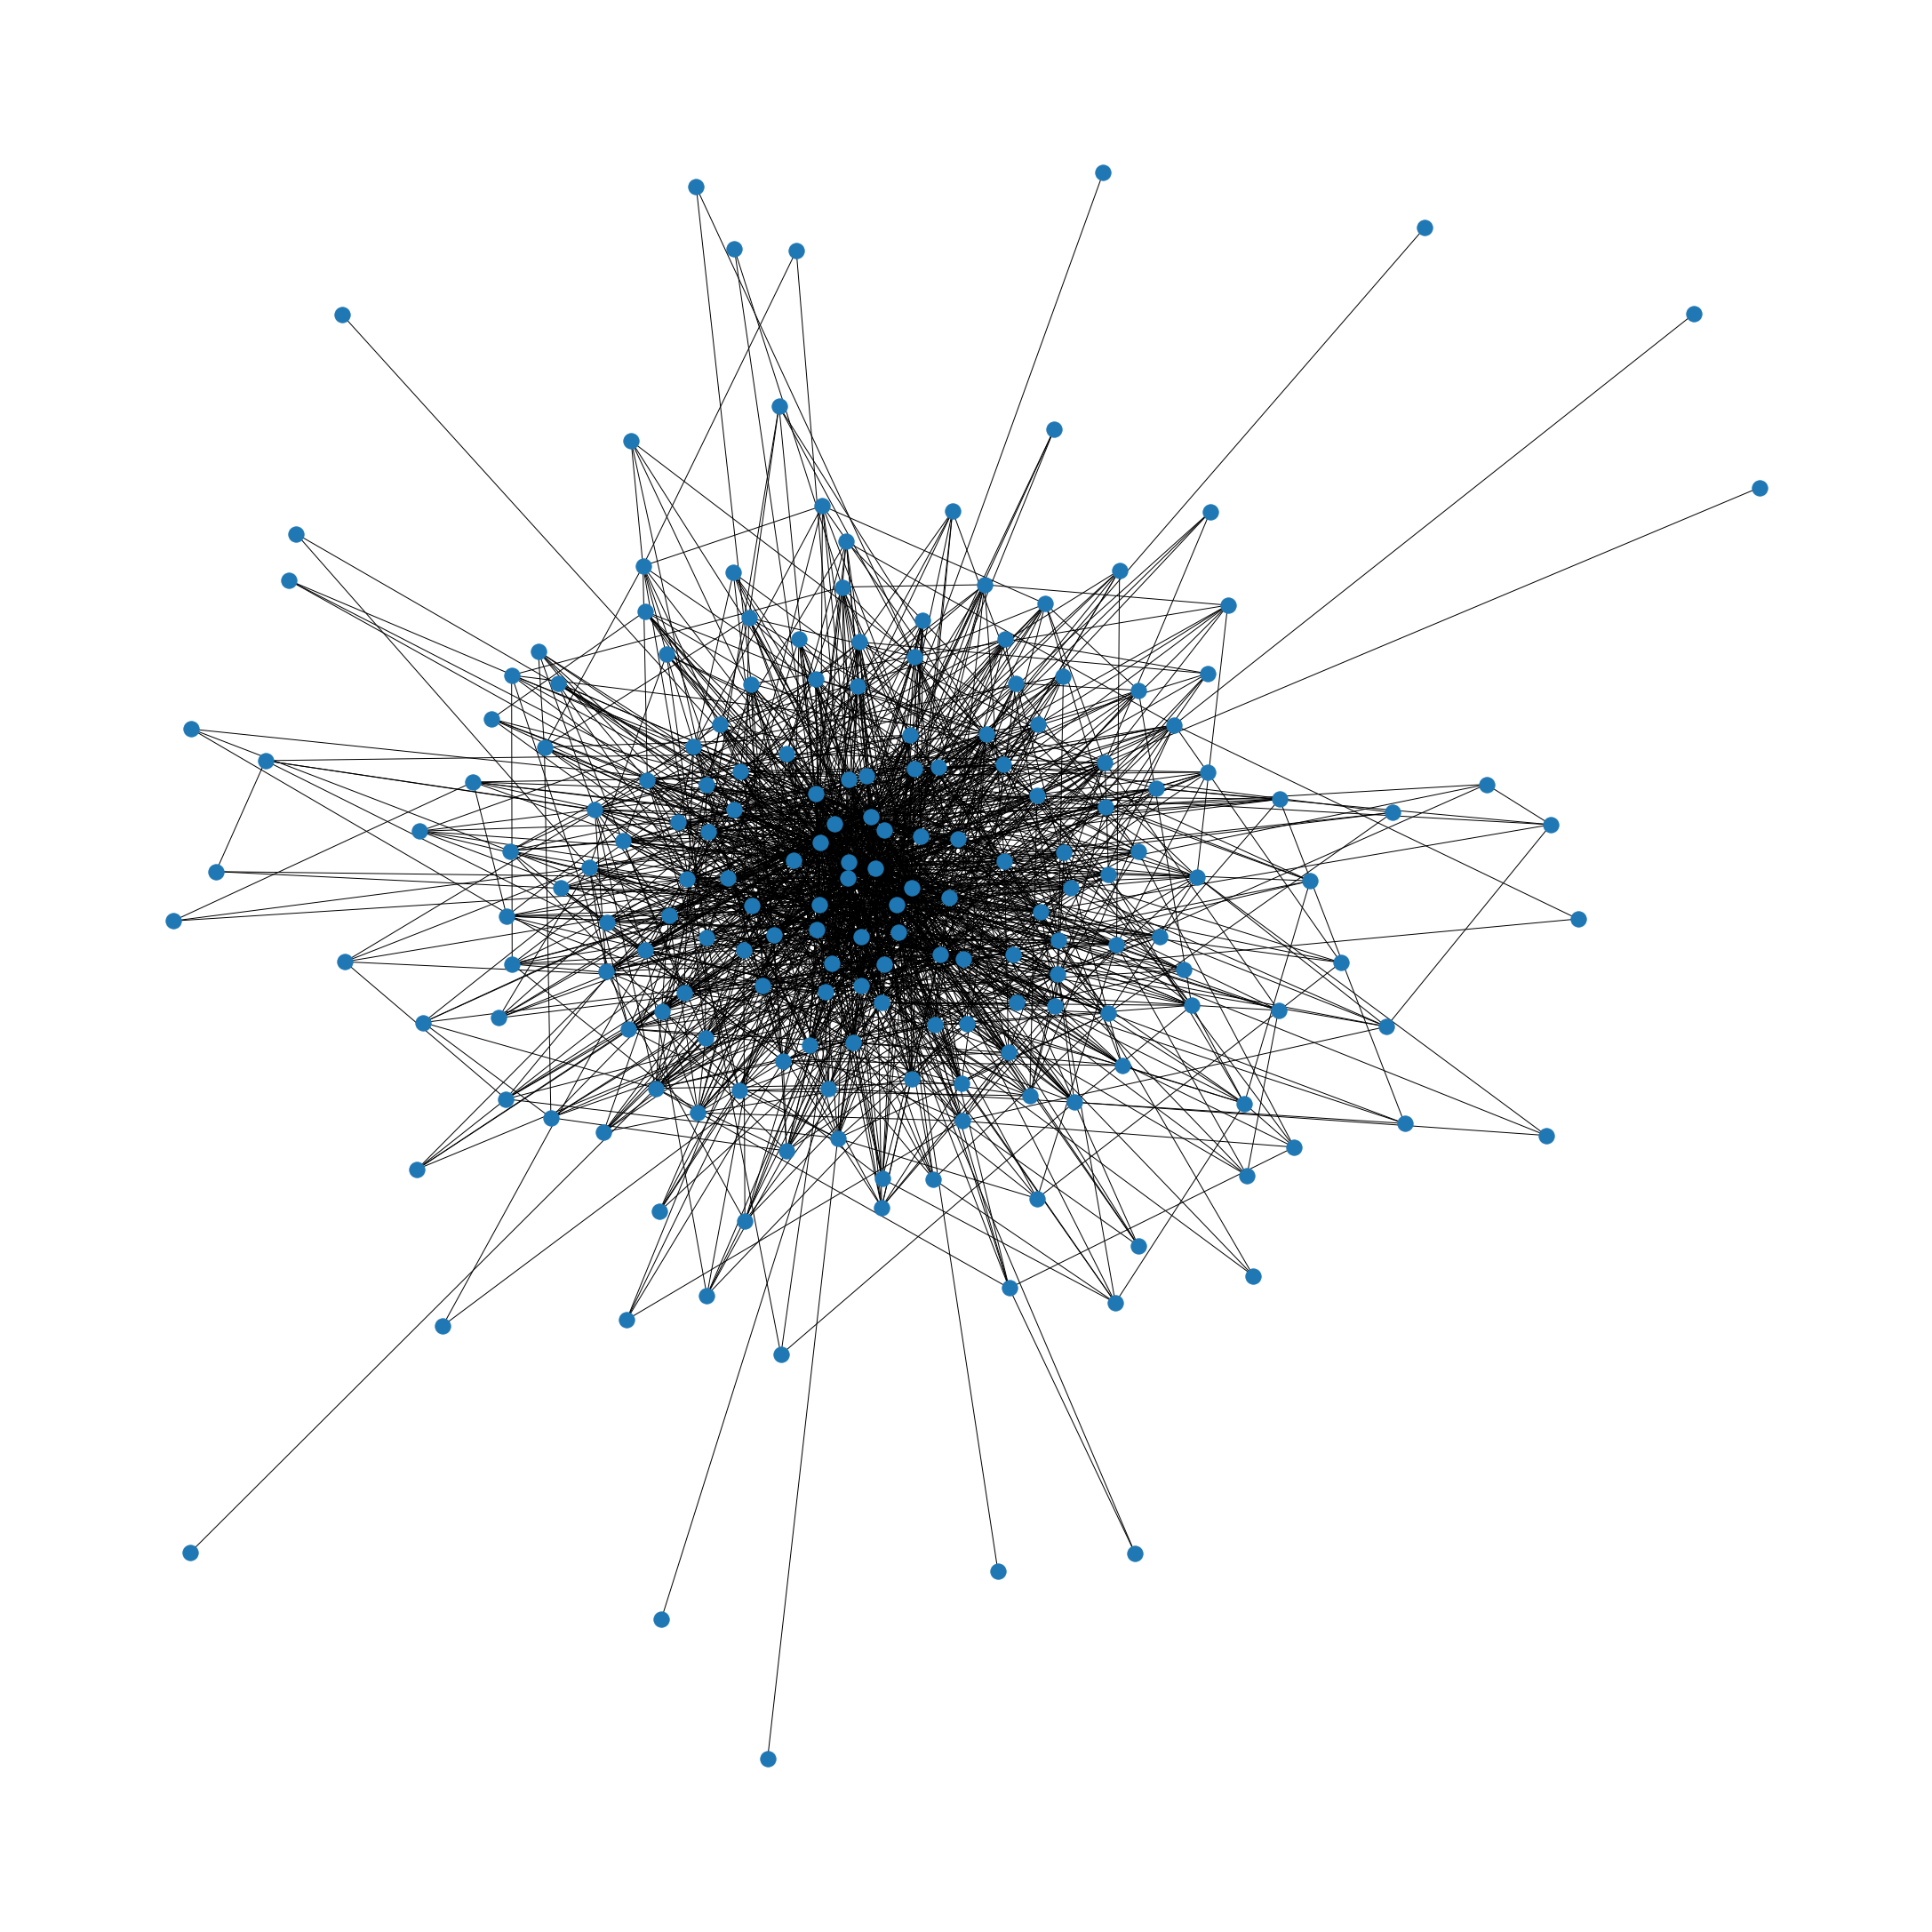

In [25]:
plt.figure(3,figsize=(30,30)) 
nx.draw(G1)
plt.show()

In [29]:
print(nx.shortest_path(G1, source="1001", target="9015", weight = "avg_ride_time"))
print(nx.shortest_path_length(G1, source="1001", target="9015", weight="avg_ride_time", method='dijkstra'))

['1001', '9015']
533.0
